[3.56739933e+07 1.21813614e+08 2.14711172e+08 2.97565410e+08
 3.67879441e+08]
[3.56739933e+09 1.21813614e+10 2.14711172e+10 2.97565410e+10
 3.67879441e+10]
[3.56739933e+07 1.21813614e+08 2.14711172e+08 2.97565410e+08
 3.67879441e+08]
[3.56739933e+09 1.21813614e+10 2.14711172e+10 2.97565410e+10
 3.67879441e+10]
[3.56739933e+07 1.21813614e+08 2.14711172e+08 2.97565410e+08
 3.67879441e+08]
[3.56739933e+09 1.21813614e+10 2.14711172e+10 2.97565410e+10
 3.67879441e+10]


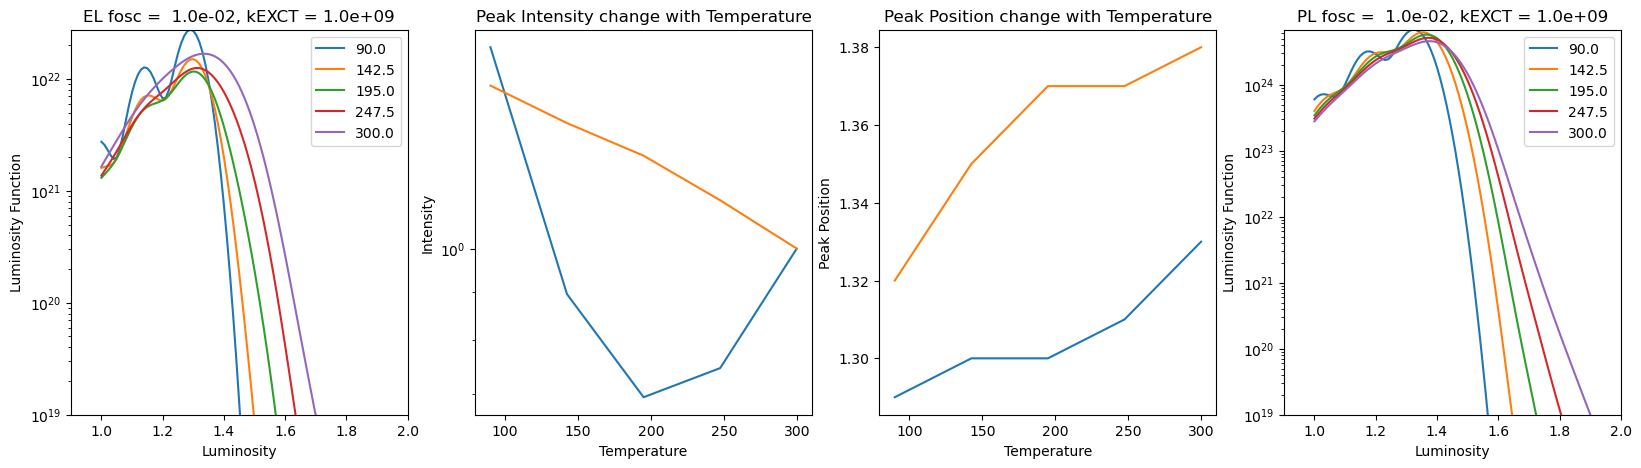

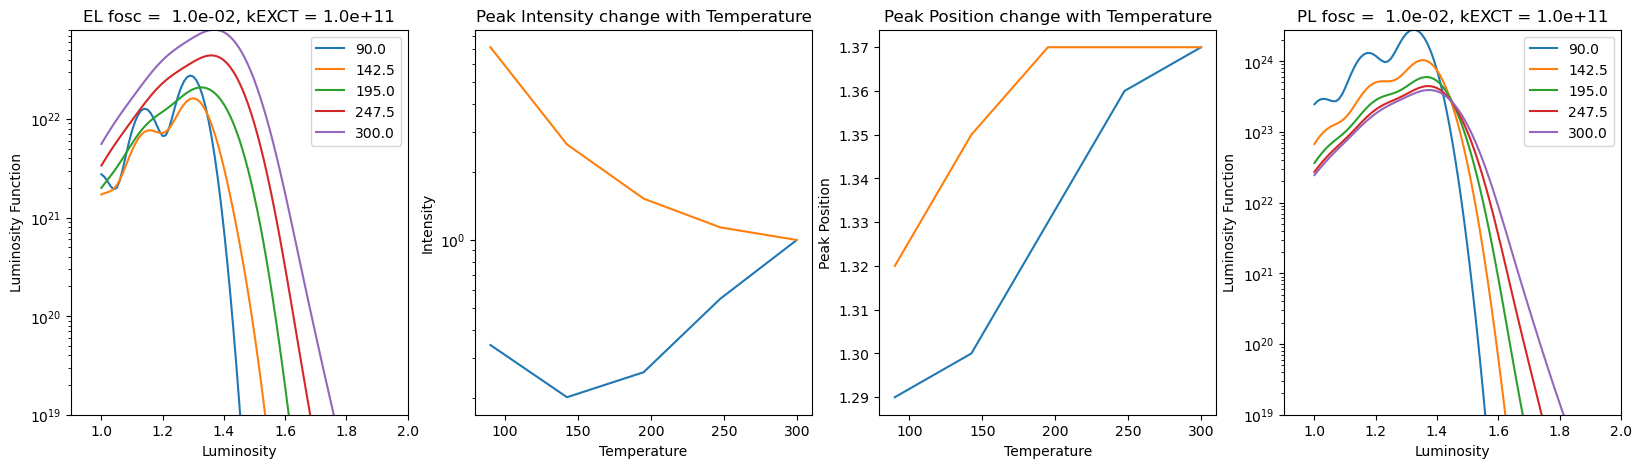

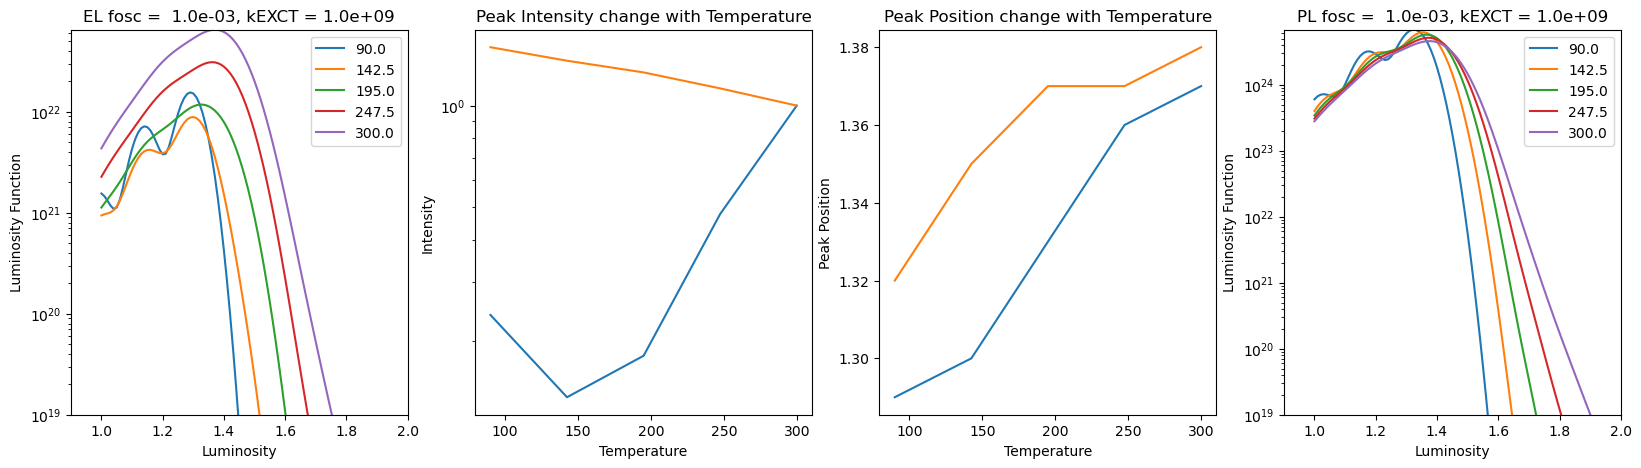

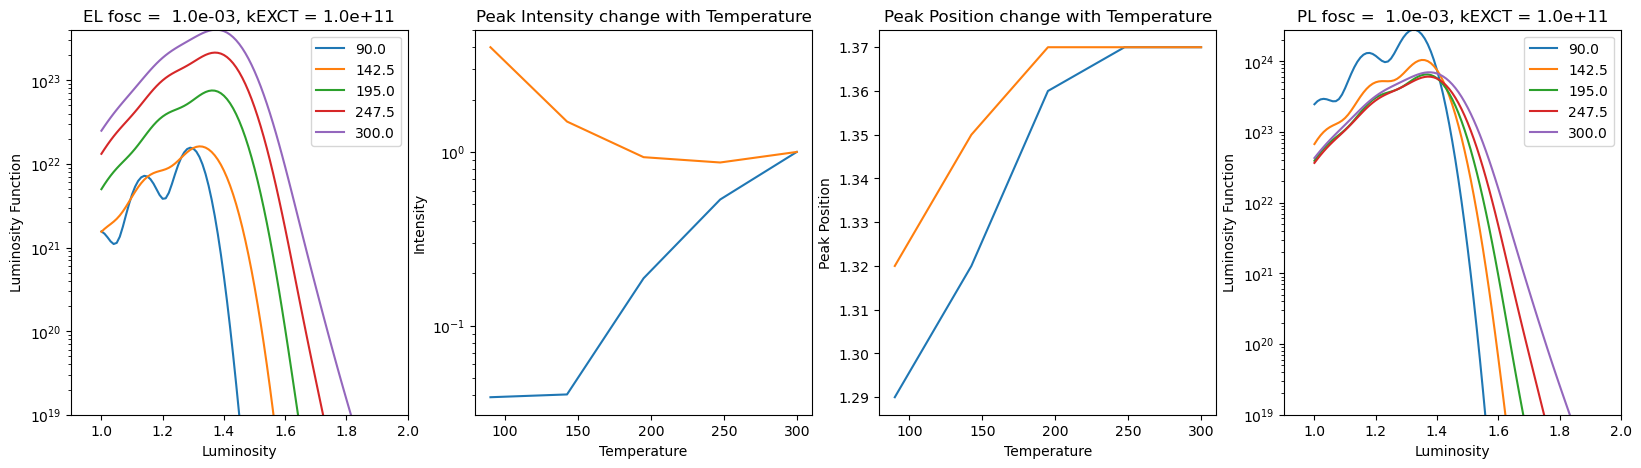

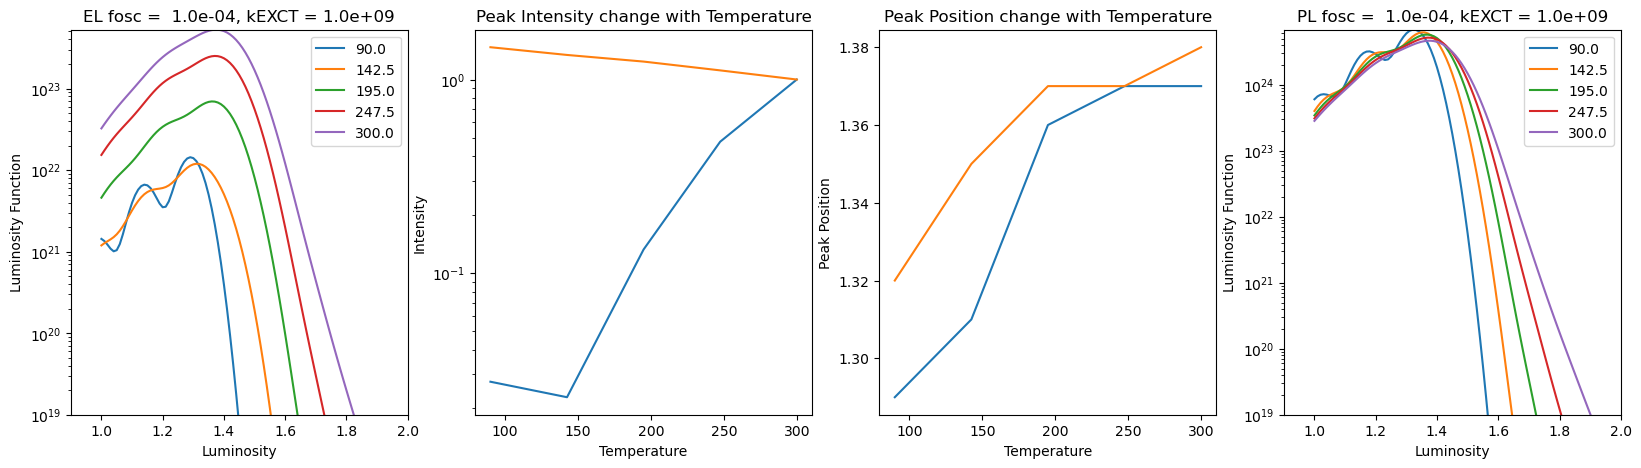

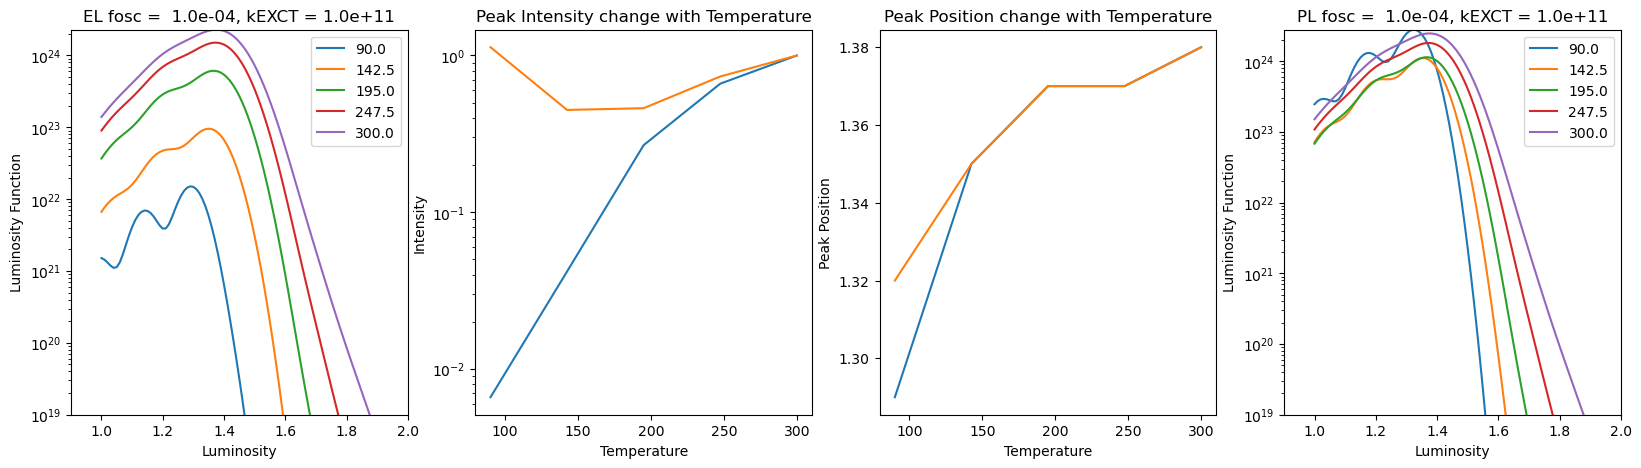

In [5]:
from pl_temp_fit import LTL
import importlib
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
importlib.reload(LTL)

def plot_data(data):
        data = LTL.LTLCalc(data)
        
        fig, ax = plt.subplots(1,4,figsize=(20,5))
        ax[0].plot(data.D.hw, data.D.kr_hw,label = data.D.T)
        ax[0].set_xlabel('Luminosity')
        ax[0].set_ylabel('Luminosity Function')
        ax[0].legend()
        ax[0].set_xlim(0.9, 2)
        ax[0].set_ylim(1e19,np.max(data.D.kr_hw))
        ax[0].set_yscale('log')
        ax[3].set_title(f"fosc =  {fosc:.1e}")
        max_int = np.max(data.D.kr_hw,axis=0)/np.max(data.D.kr_hw,axis=0)[-1]
        peak_pos = data.D.hw[np.argmax(data.D.kr_hw,axis=0)]
        ax[1].plot(data.D.T, max_int)
        ax[1].set_xlabel('Temperature')
        ax[1].set_ylabel('Intensity')
        ax[1].set_title(f"Peak Intensity change with Temperature")
        ax[1].set_yscale('log')
        ax[2].plot(data.D.T, peak_pos)
        ax[2].set_xlabel('Temperature')
        ax[2].set_ylabel('Peak Position')
        ax[2].set_title(f"Peak Position change with Temperature")
        data.D.Luminecence_exp = 'PL'
        data = LTL.LTLCalc(data)

        ax[3].plot(data.D.hw, data.D.kr_hw,label = data.D.T)
        ax[3].set_xlabel('Luminosity')
        ax[3].set_ylabel('Luminosity Function')
        ax[3].legend()
        ax[3].set_xlim(0.9, 2)
        ax[3].set_ylim(1e19,np.max(data.D.kr_hw))
        ax[3].set_yscale('log')
        ax[3].set_title(f"fosc =  {fosc:.1e}")
        max_int = np.max(data.D.kr_hw,axis=0)/np.max(data.D.kr_hw,axis=0)[-1]
        peak_pos = data.D.hw[np.argmax(data.D.kr_hw,axis=0)]
        ax[1].plot(data.D.T, max_int)
        ax[2].plot(data.D.T, peak_pos)
        return fig, ax
lambda_kdis= 0.01
for fosc in [1e-2,1e-3,1e-4]:
    for kEXCT in [1e9,1e11]:
        data = LTL.Data()
        data.D.T = np.linspace(90, 300, 5)

        data.D.RCTE = 1
        data.EX = LTL.State(E=1.5, vmhigh=5, vmlow=15, sigma=0.025, numbrstates=20, off=0, LI=0.1, L0=0.1, H0=0.15, fosc=5)
        data.CT = LTL.State(E=1.4, vmhigh=5, vmlow=15, sigma=0.01, numbrstates=20, off=0, LI=0.1, L0=0.1, H0=0.15, fosc=fosc)
        data.D.Luminecence_exp = 'EL'
        data.D.hw =  np.arange(1, 2, 0.01)
        data.D.kEXCT = kEXCT * np.exp(-(data.EX.E - data.CT.E)**2 * ((data.c.kb * 300) / lambda_kdis / (data.c.kb * data.D.T)))
        fig,ax = plot_data(data)
        ax[0].set_title(f"EL fosc =  {fosc:.1e}, kEXCT = {kEXCT:.1e}")
        ax[3].set_title(f"PL fosc =  {fosc:.1e}, kEXCT = {kEXCT:.1e}")
        #print(np.array2string(data.EX.kr/data.EX.knr, formatter={'float_kind':lambda x: "%.2e" % x}))
        #print(np.array2string(data.CT.kr/data.CT.knr, formatter={'float_kind':lambda x: "%.2e" % x}))
        print(data.D.kEXCT )
    #print(data.CT.knr)

[[1.41e-01 1.64e-01 1.79e-01 1.80e-01 1.73e-01]]
[[3.20e-04 2.16e-04 1.78e-04 1.58e-04 1.43e-04]]
[[1.41e-01 1.64e-01 1.79e-01 1.80e-01 1.73e-01]]
[[4.22e-04 2.85e-04 2.35e-04 2.08e-04 1.89e-04]]


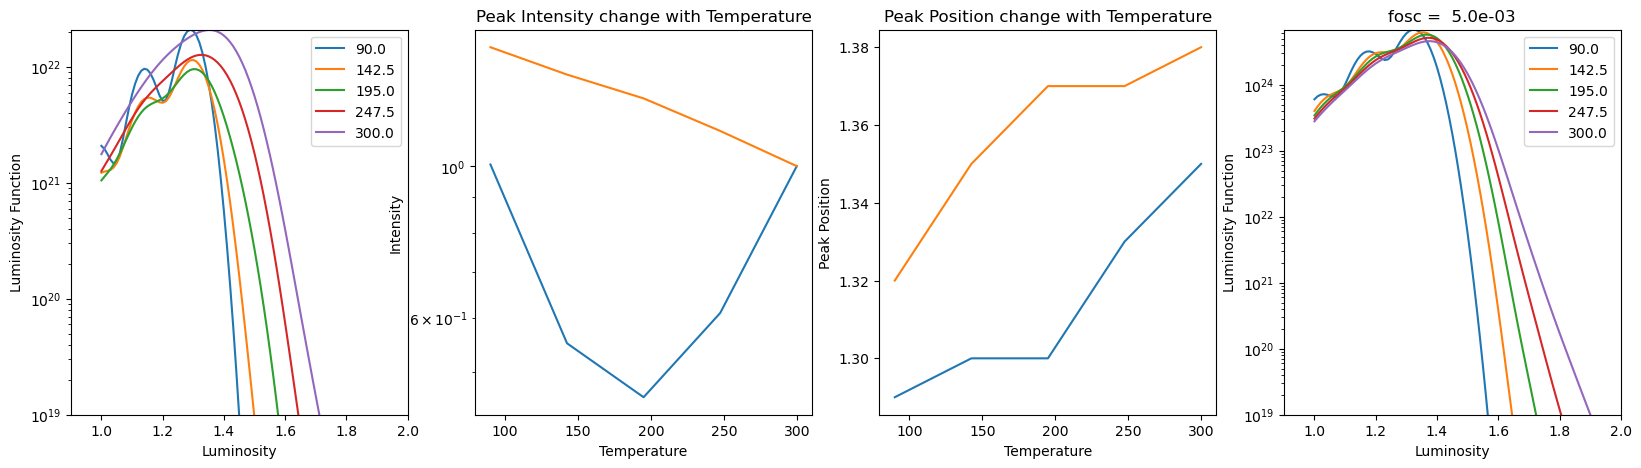

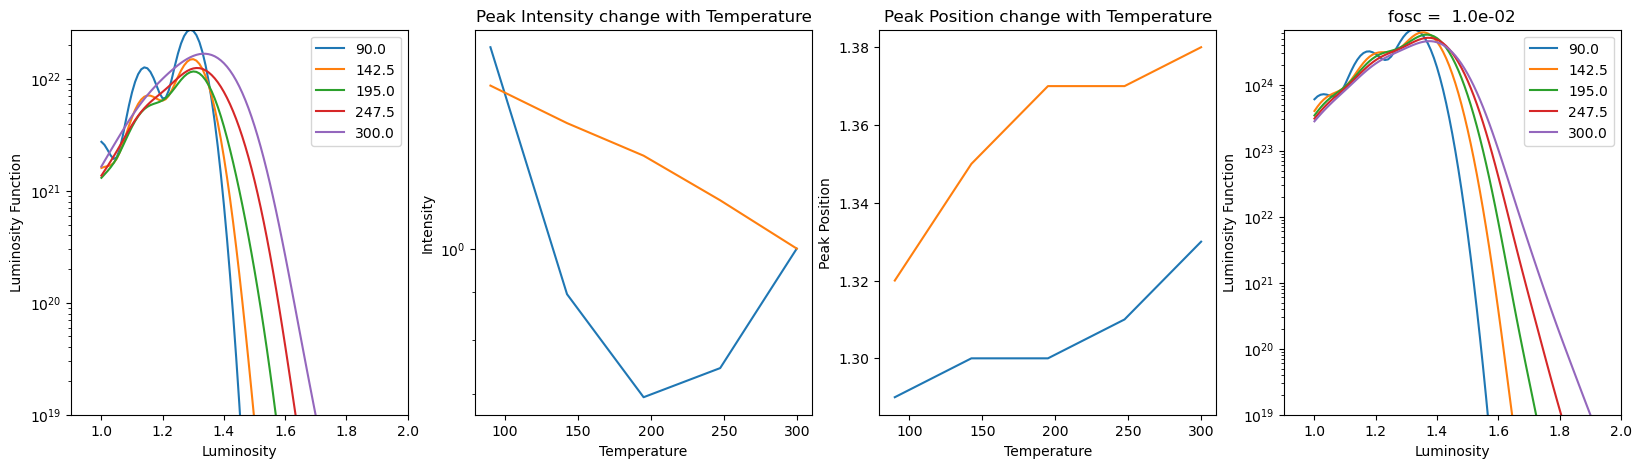

In [161]:
from pl_temp_fit import LTL
import importlib
importlib.reload(LTL)
data = LTL.Data()
for fosc in [ 0.005, 0.01]:#0.00005, 0.0001,0.0005, 0.001,

    data.D.RCTE = 1
    data.EX = LTL.State(E=1.5, vmhigh=5, vmlow=15, sigma=0.025, numbrstates=20, off=0, LI=0.1, L0=0.1, H0=0.15, fosc=5)
    data.CT = LTL.State(E=1.4, vmhigh=5, vmlow=15, sigma=0.01, numbrstates=20, off=0, LI=0.1, L0=0.1, H0=0.15, fosc=fosc)
    data.D.Luminecence_exp = 'EL'
    data.D.T = np.linspace(90, 300, 5)
    data.D.kEXCT =1e9 * np.exp(-(data.EX.E - data.CT.E)**2 * ((data.c.kb * 300) / 0.01 / (data.c.kb * data.D.T)))
    data.D.hw =  np.arange(1, 2, 0.01)
    LTL.LTLCalc(data)
    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    ax[0].plot(data.D.hw, data.D.kr_hw,label = data.D.T)
    ax[0].set_xlabel('Luminosity')
    ax[0].set_ylabel('Luminosity Function')
    ax[0].legend()
    ax[0].set_xlim(0.9, 2)
    ax[0].set_ylim(1e19,np.max(data.D.kr_hw))
    ax[0].set_yscale('log')
    ax[3].set_title(f"fosc =  {fosc:.1e}")
    max_int = np.max(data.D.kr_hw,axis=0)/np.max(data.D.kr_hw,axis=0)[-1]
    peak_pos = data.D.hw[np.argmax(data.D.kr_hw,axis=0)]
    ax[1].plot(data.D.T, max_int)
    ax[1].set_xlabel('Temperature')
    ax[1].set_ylabel('Intensity')
    ax[1].set_title(f"Peak Intensity change with Temperature")
    ax[1].set_yscale('log')
    ax[2].plot(data.D.T, peak_pos)
    ax[2].set_xlabel('Temperature')
    ax[2].set_ylabel('Peak Position')
    ax[2].set_title(f"Peak Position change with Temperature")
    data.D.Luminecence_exp = 'PL'
    LTL.LTLCalc(data)

    ax[3].plot(data.D.hw, data.D.kr_hw,label = data.D.T)
    ax[3].set_xlabel('Luminosity')
    ax[3].set_ylabel('Luminosity Function')
    ax[3].legend()
    ax[3].set_xlim(0.9, 2)
    ax[3].set_ylim(1e19,np.max(data.D.kr_hw))
    ax[3].set_yscale('log')
    ax[3].set_title(f"fosc =  {fosc:.1e}")
    max_int = np.max(data.D.kr_hw,axis=0)/np.max(data.D.kr_hw,axis=0)[-1]
    peak_pos = data.D.hw[np.argmax(data.D.kr_hw,axis=0)]
    ax[1].plot(data.D.T, max_int)
    ax[2].plot(data.D.T, peak_pos)
    print(np.array2string(data.EX.kr/data.EX.knr, formatter={'float_kind':lambda x: "%.2e" % x}))
    print(np.array2string(data.CT.kr/data.CT.knr, formatter={'float_kind':lambda x: "%.2e" % x}))
#print(data.CT.knr)

[[4.32710279e+09 4.18176846e+09 4.50201980e+09 5.02500710e+09
  5.74528639e+09]]
[[1.62975439e+10 1.61442220e+10 1.81255868e+10 2.09979965e+10
  2.41111735e+10]]


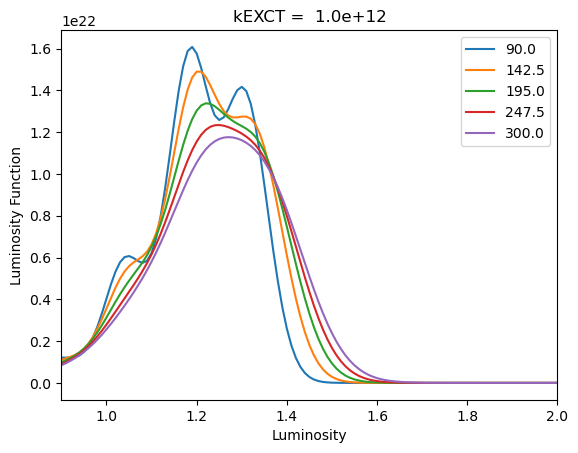

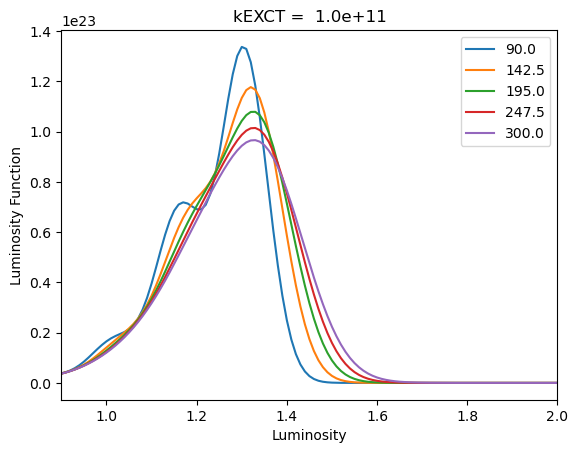

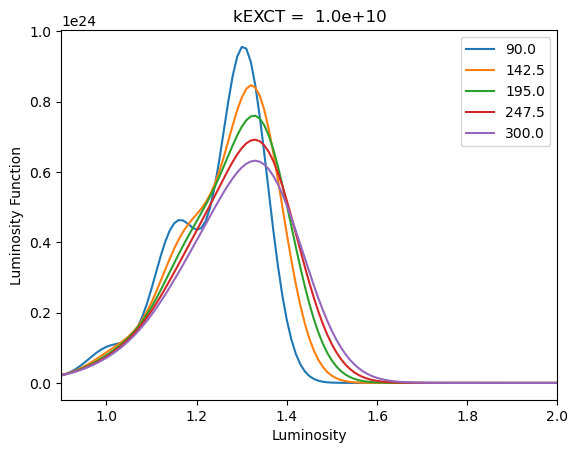

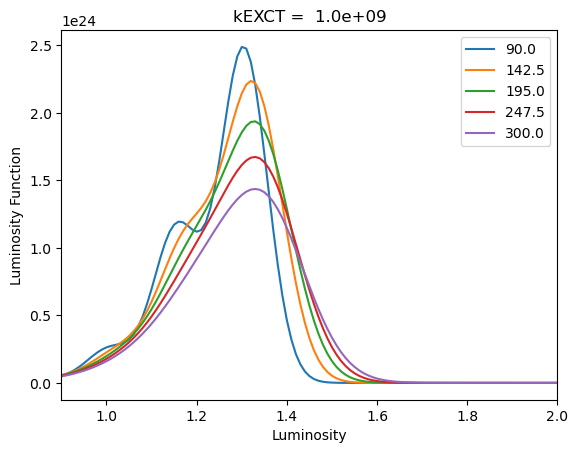

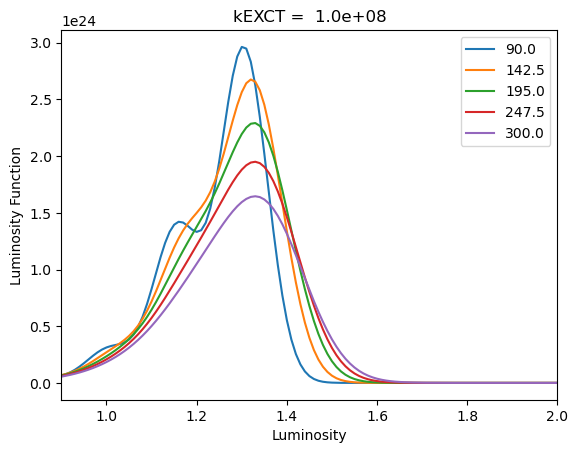

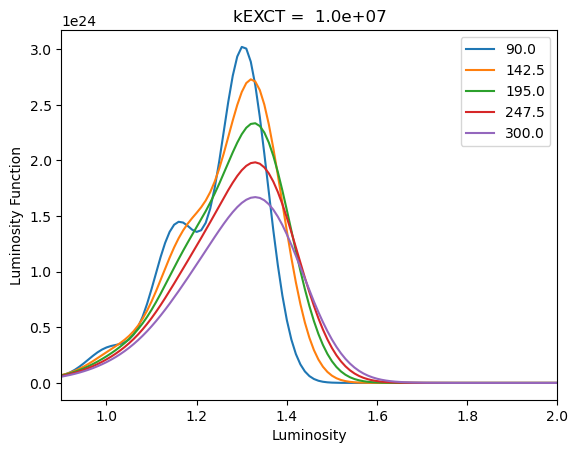

In [13]:
from pl_temp_fit import LTPL
import importlib
importlib.reload(LTPL)
data = LTPL.Data()
for k_EXCT in [1e12, 1e11, 1e10, 1e9, 1e8, 1e7]:
    data.D.kEXCT = k_EXCT
    data.EX = LTPL.State(E=1.5, vmhigh=5, vmlow=15, sigma=0.02, numbrstates=20, off=0, LI=0.1, L0=0.15, H0=0.15, fosc=5)
    data.CT = LTPL.State(E=1.3, vmhigh=5, vmlow=15, sigma=0.01, numbrstates=20, off=0, LI=0.1, L0=0.1, H0=0.15, fosc=0.05)
    LTPL.LTPLCalc(data)
    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots()
    ax.plot(data.D.hw, data.D.kr_hw,label = data.D.T)
    ax.set_xlabel('Luminosity')
    ax.set_ylabel('Luminosity Function')
    ax.legend()
    ax.set_xlim(0.9, 2)
    #ax.set_ylim(1e19, 1e40)
    ax.set_yscale('linear')
    ax.set_title(f"kEXCT =  {k_EXCT:.1e}")

print(data.EX.knr)
print(data.CT.knr)

knr
4.3271e+09
4.1818e+09
4.5020e+09
5.0250e+09
5.7453e+09
kr
2.8580e+08
2.9996e+08
3.0721e+08
3.1223e+08
3.1690e+08


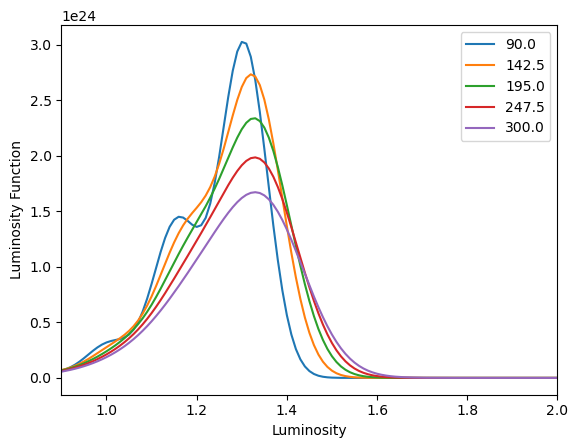

In [5]:
from pl_temp_fit import LTPL

data = LTPL.Data()
data.EX = LTPL.State(E=1.5, vmhigh=5, vmlow=15, sigma=0.02, numbrstates=20, off=0, LI=0.1, L0=0.15, H0=0.15, fosc=5)
data.CT = LTPL.State(E=1.1, vmhigh=2, vmlow=2, sigma=0.01, numbrstates=20, off=1, LI=0.1, L0=0.1, H0=0.15, fosc=5)
LTPL.LTPLCalc(data)
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.plot(data.D.hw, data.D.kr_hw,label = data.D.T)
ax.set_xlabel('Luminosity')
ax.set_ylabel('Luminosity Function')
ax.legend()
ax.set_xlim(0.9, 2)
#ax.set_ylim(1e19, 1e40)
ax.set_yscale('linear')
# print in scientific notation
print("knr")
for x in data.EX.knr[0]:
    print("{:10.4e}".format(x))
# print in scientific notation
print("kr")
for x in data.EX.kr:
    print("{:10.4e}".format(x))

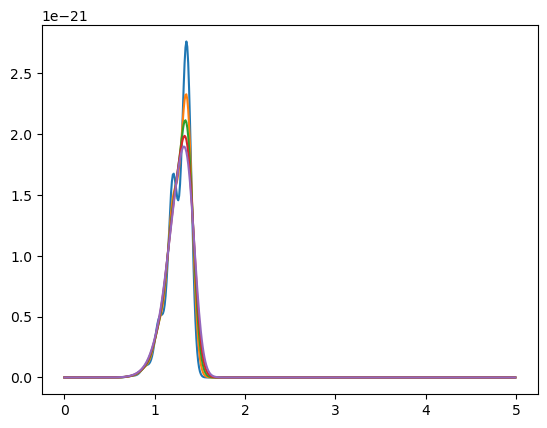

In [6]:
fig, ax = plt.subplots()
ax.plot(data.D.hw, data.EX.ka_hw,label = data.D.T)

In [3]:

print(data.EX.M)
print(data.EX.V)
print(data.EX.FCWD[:,0,0].max())
print(data.EX.Sum)
print(data.EX.Gen)

6.763524363633578e-10
0.699255508626945
1.2032927909902044e-34
[1.24733825e+15 1.25037993e+15 1.23607640e+15 1.20923399e+15
 1.17320161e+15]
[1.e+25 1.e+25 1.e+25 1.e+25 1.e+25]


In [16]:
# print in scientific notation
print("knr")
for x in data.EX.knr:
    print("{:10.4e}".format(x))
# print in scientific notation
print("kr")
for x in data.EX.kr:
    print("{:10.4e}".format(x))

knr
7.7248e+09
7.7117e+09
7.8481e+09
8.0988e+09
8.4469e+09
kr
2.9224e+08
2.9537e+08
2.9810e+08
3.0078e+08
3.0365e+08


In [3]:
print(data.EX.kr_hw
      )


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.83744942e-13 1.33443071e-12 2.93444898e-12 6.22394212e-12
  1.27632563e-11]
 [4.93136908e-05 7.55698390e-05 1.13572199e-04 1.67608406e-04
  2.43181128e-04]
 [4.29584750e+02 4.56954945e+02 4.85169901e+02 5.14193664e+02
  5.43989789e+02]
 [6.42453840e+08 4.91181984e+08 3.80856504e+08 2.99175339e+08
  2.37853793e+08]
 [1.93520815e+14 1.10112051e+14 6.44543811e+13 3.87319829e+13
  2.38486445e+13]
 [1.26069923e+19 5.52783473e+18 2.52505401e+18 1.19801304e+18
  5.88781441e+17]
 [1.84492781e+23 6.45488592e+22 2.37848953e+22 9.19572828e+21
  3.71762881e+21]
 [6.20401126e+26 1.79339799e+26 5.51043148e+25 1.79178250e+25
  6.14103786e+24]
 [4.86460023e+29 1.20303495e+29 3.18629649e+28 8.99344067e+27
  2.69310707e+27]
 [8.98556074e+31 1.96862110e+31 4.64625817e+30 1.17501887e+30
  3.16869670e+29]
 [3.94972969e+33 7.94245956e+32 1.72787675e+32 4.04380585e+31
  1.01290075e+31]
 [4.30360680e+34 8.25845790e+33 1.719160

In [ ]:
np.tile(np.arange(0, 5 + 1), (16, 1)).shape
hw = np.arange(0, 5 + 1)
T = np.arange(290, 300)
Lagur, energy, deltaG, final, initial = FCWD_v(data.EX,data.c,hw,T)

In [10]:
import numpy as np
from scipy.special import factorial, genlaguerre
t_array = np.arange(0, 5 )
w_array = np.arange(0, 15 )
lag = np.zeros((len(t_array), len(w_array)))
from itertools import product
for t, w in product(t_array, w_array):
    #print(t,w)
    if w-t>0:
        lag[t, w] = genlaguerre(t, w-t)(0.6) 
    
lag


array([[0.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 1.400000e+00, 2.400000e+00,
        3.400000e+00, 4.400000e+00, 5.400000e+00, 6.400000e+00,
        7.400000e+00, 8.400000e+00, 9.400000e+00, 1.040000e+01,
        1.140000e+01, 1.240000e+01, 1.340000e+01],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 1.380000e+00,
        3.780000e+00, 7.180000e+00, 1.158000e+01, 1.698000e+01,
        2.338000e+01, 3.078000e+01, 3.918000e+01, 4.858000e+01,
        5.898000e+01, 7.038000e+01, 8.278000e+01],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.084000e+00, 4.864000e+00, 1.204400e+01, 2.362400e+01,
        4.060400e+01, 6.398400e+01, 9.476400e+01, 1.339440e+02,
        1.825240e+02, 2.415040e+02, 3.118840e+02],
       [0.000000e+00, 0.0000

In [7]:
np.take(lag, [[0, 1, 2, 3],[0, 1, 2, 3]], axis=1)

array([[[ 1.   ,  0.   ,  0.   ,  0.   ],
        [ 1.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.4  ,  0.   ,  0.   ],
        [ 0.   ,  0.4  ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   , -0.02 ,  0.   ],
        [ 0.   ,  0.   , -0.02 ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   , -0.296],
        [ 0.   ,  0.   ,  0.   , -0.296]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.

In [5]:
lag

array([[ 1.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.4     ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , -0.02    ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , -0.296   ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , -0.4586  ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      , -0.533648],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.   

In [ ]:
(final - initial) * factorial(initial) / factorial(final)